# Compiling County-Level Data

## Overview

This notebook compiles a dataset of county-level population, employment, and economic indicators from various sources including the American Community Survey (ACS), Bureau of Labor Statistics Local Area Unemployment Statistics (BLS LAUS), and Bureau of Economic Analysis. The data spans from 2010 to 2024.

## Getting Started
1. Download the required libraries:
    ```bash
    pip install -r requirements.txt
    ```

2. Create the `data/` directory and place the downloaded data files in the appropriate subdirectories as specified in the sources section.
    ```bash
    cd predicting-labor-market-trends
    mkdir data
    mkdir data/bls
    mkdir data/bea
    ```

## Sources

If API is not specified, data must be downloaded manually.

- *BLS LAUS*: https://www.bls.gov/lau/tables.htm#cntyaa (Download laucnty[YY].xlsx for each year)
- *BEA CAGDP1*: https://apps.bea.gov/regional/downloadzip.htm (Download CAGDP1 folder under GDP tab)

## Data Dictionary
| Column Name               | Description                                      | Source                     |
|---------------------------|--------------------------------------------------|----------------------------|
| FIPS5                    | 5-digit FIPS code for the county                 | BLS                        |

In [66]:
import pandas as pd
import requests

YEARS = range(2010, 2024)

In [67]:
# 1. Loading BLS (Unemployment by County)
BLS = pd.DataFrame()
dtype = {
    'State FIPS Code': str,
    'County FIPS Code': str,
}

# Load each year's data and concatenate
for year in YEARS:
    df = pd.read_excel(f'./data/bls/laucnty{str(year)[-2:]}.xlsx', skiprows=1, dtype=dtype)
    df['Year'] = year
    BLS = pd.concat([BLS, df], ignore_index=True)

# Create FIPS5 code - combination of State and County FIPS codes
BLS['FIPS5'] = BLS['State FIPS Code'] + BLS['County FIPS Code']

# Drop unnecessary columns and rows with missing FIPS5
BLS.drop(columns=['LAUS Code', 'County Name/State Abbreviation', 'State FIPS Code', 'County FIPS Code'], inplace=True)
BLS.dropna(subset=['FIPS5'], inplace=True)

BLS

,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%),FIPS5
0,2010,25972.0,23688.0,2284.0,8.8,01001
1,2010,84269.0,75943.0,8326.0,9.9,01003
2,2010,10307.0,9057.0,1250.0,12.1,01005
3,2010,9012.0,8000.0,1012.0,11.2,01007
4,2010,25142.0,22706.0,2436.0,9.7,01009
...,...,...,...,...,...,...
45118,2023,18428.0,17344.0,1084.0,5.9,72145
45119,2023,2801.0,2689.0,112.0,4.0,72147
45120,2023,7250.0,6416.0,834.0,11.5,72149
45121,2023,9314.0,8548.0,766.0,8.2,72151


In [68]:
# 2. Loading BEA (Real GDP by County)
dtype = {
    'GeoFIPS': str,
}
years = [str(year) for year in YEARS]

# Load BEA data
BEA = pd.read_csv('./data/bea/CAGDP1__ALL_AREAS_2001_2023.csv', dtype=dtype, encoding='latin1', skipfooter=4)
BEA = BEA.rename(columns={'GeoFIPS': 'FIPS5'})

# Remove quotes and whitespace from FIPS5 codes
BEA['FIPS5'] = BEA['FIPS5'].str.replace('"', '').str.strip()

# Drop unnecessary columns 
BEA = BEA.drop(columns=[str(year) for year in range(2001, 2010)] + ['GeoName', 'LineCode', 'Region', 'TableName', 'LineCode', 'IndustryClassification', 'Description', 'Unit'])

# Melt the DataFrame from wide to long format (initially each year is a separate column)
BEA = BEA.melt(id_vars=['FIPS5'], value_vars=years, var_name='Year', value_name='GDP')
BEA['Year'] = BEA['Year'].astype(int)

# Drop rows with missing FIPS5
BEA.dropna(subset=['FIPS5'], inplace=True)
BEA

/var/folders/zx/x6hb1_p95p33hh3235qrnlqm0000gn/T/ipykernel_78893/2065249408.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  BEA = pd.read_csv('./data/bea/CAGDP1__ALL_AREAS_2001_2023.csv', dtype=dtype, encoding='latin1', skipfooter=4)


,FIPS5,Year,GDP
0,00000,2010,16789750000
1,00000,2010,85.609
2,00000,2010,15048971000
3,01000,2010,199454968
4,01000,2010,92.078
...,...,...,...
133471,97000,2023,125.650
133472,97000,2023,1057159025
133473,98000,2023,4525827912
133474,98000,2023,119.181


In [69]:
# 3. Merge Datasets into master panel
df = pd.merge(BLS, BEA, on=['FIPS5', 'Year'], how='left')
df

,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%),FIPS5,GDP
0,2010,25972.0,23688.0,2284.0,8.8,01001,1409007
1,2010,25972.0,23688.0,2284.0,8.8,01001,79.941
2,2010,25972.0,23688.0,2284.0,8.8,01001,1262883
3,2010,84269.0,75943.0,8326.0,9.9,01003,6012889
4,2010,84269.0,75943.0,8326.0,9.9,01003,81.447
...,...,...,...,...,...,...,...
131355,2023,18428.0,17344.0,1084.0,5.9,72145,NaN
131356,2023,2801.0,2689.0,112.0,4.0,72147,NaN
131357,2023,7250.0,6416.0,834.0,11.5,72149,NaN
131358,2023,9314.0,8548.0,766.0,8.2,72151,NaN


In [70]:
print("Compiled dataset shape:", df.shape)
print("Number of unique counties:", df['FIPS5'].nunique())
print("Number of counties for each year:", df.groupby('Year')['FIPS5'].nunique())
print("Years covered:", df['Year'].min(), "to", df['Year'].max())

Compiled dataset shape: (131360, 7)
Number of unique counties: 3222
Number of counties for each year: Year
2010    3220
2011    3220
2012    3220
2013    3220
2014    3220
2015    3220
2016    3220
2017    3220
2018    3220
2019    3220
2020    3221
2021    3221
2022    3221
2023    3221
Name: FIPS5, dtype: int64
Years covered: 2010 to 2023


In [71]:
# 4. Descriptive statistics of relevant columns
vars = ['Labor Force', 'Employed', 'Unemployed', 'Unemployment Rate (%)', 'GDP']
df[vars] = df[vars].apply(pd.to_numeric, errors='coerce')
df[vars].describe(include='all')

,Labor Force,Employed,Unemployed,Unemployment Rate (%),GDP
count,1.312820e+05,1.312820e+05,131282.000000,131282.000000,1.294060e+05
mean,5.035962e+04,4.738400e+04,2975.618775,5.901689,4.127815e+06
std,1.653585e+05,1.546871e+05,11802.400790,2.926622,2.267505e+07
min,2.100000e+01,1.800000e+01,3.000000,1.100000,4.977000e+00
25%,4.837000e+03,4.536000e+03,255.000000,3.700000,1.066430e+02
50%,1.142300e+04,1.074900e+04,660.000000,5.200000,3.797675e+05
75%,3.121300e+04,2.931300e+04,1843.000000,7.400000,1.577132e+06
max,5.163996e+06,4.932292e+06,621295.000000,29.100000,9.619081e+08


In [72]:
print("Missing data proportions:")
df[vars].isna().sum() / len(df)

Missing data proportions:


Labor Force              0.000594
Employed                 0.000594
Unemployed               0.000594
Unemployment Rate (%)    0.000594
GDP                      0.014875
dtype: float64

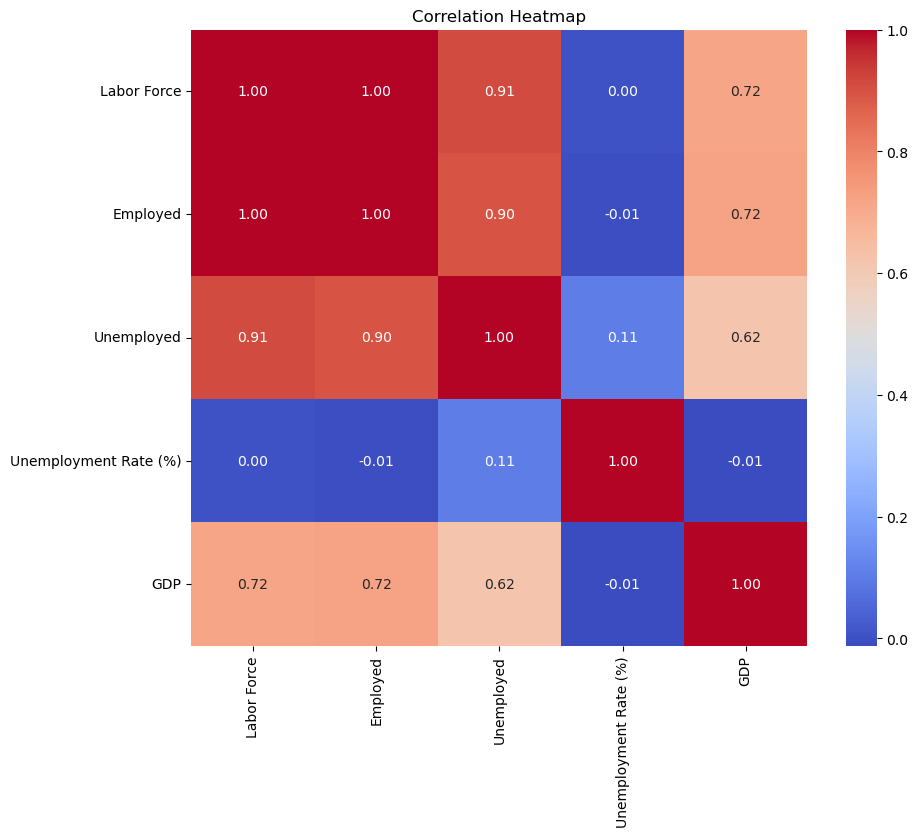

In [73]:
# 5. Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()